# Import

In [1]:
import os
import sys

import time
import math
import json
import glob
from datetime import datetime

import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt

import cv2
import torch
from torch.nn.functional import mse_loss
from pytorch_kinematics.transforms.rotation_conversions import matrix_to_axis_angle, axis_angle_to_matrix

import pytorch_kinematics as pk
from pytransform3d.urdf import UrdfTransformManager
from urdf_parser_py.urdf import URDF

# Helper Functions

In [2]:
def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

def forward_kinematics(V, 
                       cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                       l_rvec, l_tvec, r_rvec, r_tvec):
    
    # Convert to Tensor
    cmd_lnt = torch.Tensor(cmd_lnt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lnp = torch.Tensor(cmd_lnp).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_unt = torch.Tensor(cmd_unt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_et = torch.Tensor(cmd_et).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lep = torch.Tensor(cmd_lep).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_rep = torch.Tensor(cmd_rep).reshape(-1,1).to(dtype=dtype, device=device)

    l_rvec_t = torch.Tensor(l_rvec).to(dtype=dtype, device=device)
    l_tvec_t = torch.Tensor(l_tvec).to(dtype=dtype, device=device)
    r_rvec_t = torch.Tensor(r_rvec).to(dtype=dtype, device=device)
    r_tvec_t = torch.Tensor(r_tvec).to(dtype=dtype, device=device)

    #Joint-to-Motor Polynomial Models
    neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt @ torch.Tensor([V[var2idx['neck_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp @ torch.Tensor([V[var2idx['neck_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt @ torch.Tensor([V[var2idx['head_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et @ torch.Tensor([V[var2idx['eyes_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep @ torch.Tensor([V[var2idx['lefteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep @ torch.Tensor([V[var2idx['righteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)

    # URDF Variable Assignment
    for joint in robot.joints:
        if joint.name == 'torso':
            joint.origin.position[0] = V[var2idx['torso_origin_x']]
            joint.origin.position[1] = V[var2idx['torso_origin_y']]
            joint.origin.position[2] = V[var2idx['torso_origin_z']]
        elif joint.name == 'neck_pitch':
            joint.origin.rotation[0] = V[var2idx['neck_pitch_rot_r']]
        elif joint.name == 'head_pitch':
            joint.origin.position[2] = V[var2idx['head_pitch_origin_z']]
        elif joint.name == 'eyes_pitch':
            joint.origin.position[0] = V[var2idx['eyes_pitch_origin_x']]
            joint.origin.position[2] = V[var2idx['eyes_pitch_origin_z']]
        elif joint.name == 'lefteye_yaw':
            joint.origin.position[1] = V[var2idx['lefteye_yaw_origin_y']]
        elif joint.name == 'righteye_yaw':
            joint.origin.position[1] = -V[var2idx['lefteye_yaw_origin_y']]
        elif joint.name == 'lefteye_cam':
            joint.origin.position[0] = V[var2idx['lefteye_cam_origin_x']]
            joint.origin.rotation[0] = V[var2idx['lefteye_cam_rot_r']]
            joint.origin.rotation[2] = V[var2idx['lefteye_cam_rot_y']]
        elif joint.name == 'righteye_cam':
            joint.origin.position[0] = V[var2idx['righteye_cam_origin_x']]
            joint.origin.rotation[0] = V[var2idx['righteye_cam_rot_r']]
            joint.origin.rotation[2] = V[var2idx['righteye_cam_rot_y']]
    
    # XML to String
    urdf_str = xml_to_str(robot)
    
    # Kinematic Chain
    chain = pk.build_chain_from_urdf(urdf_str)
    chain.to(dtype=dtype, device=device)
    
    # Specifying Joint Angles (radians)
    joint_cmd = torch.cat((neck_pitch.reshape(-1,1), neck_yaw.reshape(-1,1), head_pitch.reshape(-1,1), eyes_pitch.reshape(-1,1), lefteye_yaw.reshape(-1,1), righteye_yaw.reshape(-1,1)), dim=1)

    # Forward Kinematics
    ret = chain.forward_kinematics(joint_cmd)

    # Realsense to Left Eye Camera (Pytorch) with Points
    T_clprime = torch.linalg.inv(ret['leftcamera'].get_matrix()) @ ret['realsense'].get_matrix()
    
    # Realsense to Right Eye Camera (Pytorch) with Points
    T_crprime = torch.linalg.inv(ret['rightcamera'].get_matrix()) @ ret['realsense'].get_matrix()

    # Rvec and Tvec
    out_l_rvec = matrix_to_axis_angle(T_clprime[:,:3,:3])
    out_l_tvec = T_clprime[:,:3,3]
    out_r_rvec = matrix_to_axis_angle(T_crprime[:,:3,:3])
    out_r_tvec = T_crprime[:,:3,3]

    # Return Output
    return out_l_rvec, out_l_tvec, out_r_rvec, out_r_rvec, out_r_tvec

# Initialization

In [3]:
# Explicitly telling to use GPU
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

In [4]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace_cam_true.urdf")
robot = URDF.from_xml_file(urdf_path)

## Load Dataset

In [5]:
# Load Dataset CSV

data_fn = "240927_075m_grace_dataset.csv"
data_dir = "final"
csv_file = os.path.join(os.getcwd(),"..","data", data_dir, data_fn)
temp_df = pd.read_csv(csv_file)
print(temp_df.shape)

(72533, 32)


In [6]:
# Convert DF Degrees Column to Radians
data_df = temp_df.copy()
data_df['cmd_theta_lower_neck_pan'] = np.radians(data_df['cmd_theta_lower_neck_pan'].values)
data_df['cmd_theta_lower_neck_tilt'] = np.radians(data_df['cmd_theta_lower_neck_tilt'].values)
data_df['cmd_theta_upper_neck_tilt'] = np.radians(data_df['cmd_theta_upper_neck_tilt'].values)
data_df['cmd_theta_left_eye_pan'] = np.radians(data_df['cmd_theta_left_eye_pan'].values)
data_df['cmd_theta_right_eye_pan'] = np.radians(data_df['cmd_theta_right_eye_pan'].values)
data_df['cmd_theta_eyes_tilt'] = np.radians(data_df['cmd_theta_eyes_tilt'].values)

## Load Optimization Results

In [7]:
# Load CSV Optimization Results

csv_fn = "20240929_020455_771894_075m_grace_results.csv"
csv_path = os.path.join(os.getcwd(),"..","results",csv_fn)
df = pd.read_csv(csv_path, index_col=0)
var_dict = dict(zip(df.index,df['learned'].values))
var_dict

{'neck_pitch_polyfit_b0': 0.1629712441967706,
 'neck_yaw_polyfit_b0': 0.0336948935494423,
 'head_pitch_polyfit_b0': 0.0709478454732965,
 'eyes_pitch_polyfit_b0': 0.0928781154853302,
 'lefteye_yaw_polyfit_b0': 0.056631313963081,
 'righteye_yaw_polyfit_b0': -0.0708884999387775,
 'neck_pitch_polyfit_b1': 0.4334052313523985,
 'neck_yaw_polyfit_b1': 0.8824064051209091,
 'head_pitch_polyfit_b1': 0.531241035765275,
 'eyes_pitch_polyfit_b1': 0.3770030383059998,
 'lefteye_yaw_polyfit_b1': 1.461506821357058,
 'righteye_yaw_polyfit_b1': 1.5981040374080078,
 'neck_pitch_rot_r': -0.0354847187729475,
 'torso_origin_x': 0.035984955683584,
 'torso_origin_y': -0.0744675391462022,
 'torso_origin_z': -0.1190279931579989,
 'head_pitch_origin_z': 0.1145613172385128,
 'eyes_pitch_origin_x': 0.0901956547376227,
 'eyes_pitch_origin_z': 0.0329010993189591,
 'lefteye_yaw_origin_y': 0.0344577986111276,
 'lefteye_cam_origin_x': 0.0234087734266175,
 'righteye_cam_origin_x': 0.0253092681092937,
 'lefteye_cam_rot_r'

In [8]:
# Decision Variables 
var_list = list(var_dict.values())

# Variable Names
var_names_list = list(var_dict.keys())

# Mapping
idx2var = dict(zip(list(range(len(var_names_list))),var_names_list))
var2idx = dict(zip(var_names_list, list(range(len(var_names_list)))))

# Evaluation

In [9]:
# Input

V = np.array(var_list)
x_c_l = data_df['x_c_l'].to_numpy()
y_c_l = data_df['y_c_l'].to_numpy()
z_c_l = data_df['z_c_l'].to_numpy()
x_c_r = data_df['x_c_r'].to_numpy()
y_c_r = data_df['y_c_r'].to_numpy()
z_c_r = data_df['z_c_r'].to_numpy()
cmd_lnt = data_df['cmd_theta_lower_neck_tilt'].to_numpy()
cmd_lnp = data_df['cmd_theta_lower_neck_pan'].to_numpy()
cmd_unt = data_df['cmd_theta_upper_neck_tilt'].to_numpy()
cmd_et = data_df['cmd_theta_eyes_tilt'].to_numpy()
cmd_lep = data_df['cmd_theta_left_eye_pan'].to_numpy()
cmd_rep = data_df['cmd_theta_right_eye_pan'].to_numpy()

l_rvec = np.concatenate([data_df['l_rvec_0'].values.reshape(-1,1),
                         data_df['l_rvec_1'].values.reshape(-1,1),
                         data_df['l_rvec_2'].values.reshape(-1,1)], axis=1)
l_tvec = np.concatenate([data_df['l_tvec_0'].values.reshape(-1,1),
                         data_df['l_tvec_1'].values.reshape(-1,1),
                         data_df['l_tvec_2'].values.reshape(-1,1)], axis=1)
r_rvec = np.concatenate([data_df['r_rvec_0'].values.reshape(-1,1),
                         data_df['r_rvec_1'].values.reshape(-1,1),
                         data_df['r_rvec_2'].values.reshape(-1,1)], axis=1)
r_tvec = np.concatenate([data_df['r_tvec_0'].values.reshape(-1,1),
                         data_df['r_tvec_1'].values.reshape(-1,1),
                         data_df['r_tvec_2'].values.reshape(-1,1)], axis=1)

In [10]:
# Fprward Kinematics

out_l_rvec, out_l_tvec, out_r_rvec, out_r_rvec, out_r_tvec = forward_kinematics(V, 
                                                                                cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                                                                                l_rvec, l_tvec, r_rvec, r_tvec)

In [11]:
# True Value

l_rvec_t = torch.Tensor(l_rvec).to(dtype=dtype, device=device)
l_tvec_t = torch.Tensor(l_tvec).to(dtype=dtype, device=device)
r_rvec_t = torch.Tensor(r_rvec).to(dtype=dtype, device=device)
r_tvec_t = torch.Tensor(r_tvec).to(dtype=dtype, device=device)

## Results

In [12]:
# Results

results_idx = ['r(rad)','p(rad)', 'y(rad)', 'x(m)','y(m)', 'z(m)',]
results_df = pd.DataFrame({'Left Eye MSE': [
                            mse_loss(out_l_rvec[:,0], l_rvec_t[:,0]).cpu().item(),
                            mse_loss(out_l_rvec[:,1], l_rvec_t[:,1]).cpu().item(),
                            mse_loss(out_l_rvec[:,2], l_rvec_t[:,2]).cpu().item(),
                            mse_loss(out_l_tvec[:,0], l_tvec_t[:,0]).cpu().item(),
                            mse_loss(out_l_tvec[:,1], l_tvec_t[:,1]).cpu().item(),
                            mse_loss(out_l_tvec[:,2], l_tvec_t[:,2]).cpu().item(),
                            ],
                          'Right Eye MSE': [
                            mse_loss(out_r_rvec[:,0], r_rvec_t[:,0]).cpu().item(),
                            mse_loss(out_r_rvec[:,1], r_rvec_t[:,1]).cpu().item(),
                            mse_loss(out_r_rvec[:,2], r_rvec_t[:,2]).cpu().item(),
                            mse_loss(out_r_tvec[:,0], r_tvec_t[:,0]).cpu().item(),
                            mse_loss(out_r_tvec[:,1], r_tvec_t[:,1]).cpu().item(),
                            mse_loss(out_r_tvec[:,2], r_tvec_t[:,2]).cpu().item(),
                          ]})
results_df.index = results_idx
results_df

,Left Eye MSE,Right Eye MSE
r(rad),0.002163,0.004920
p(rad),0.005492,0.012369
y(rad),0.005311,0.012295
x(m),0.001581,0.001655
y(m),0.001566,0.002966
z(m),0.001483,0.002204


## Absolute Error Histogram

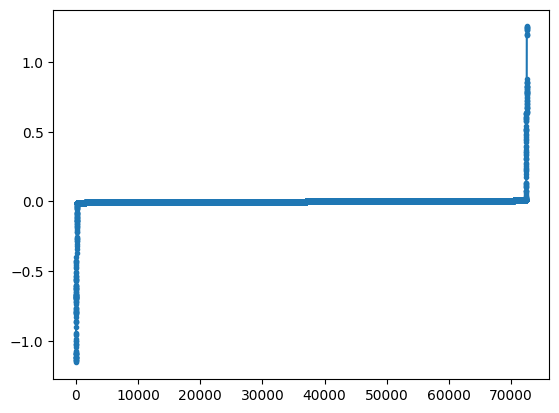

In [13]:
plt.figure()
plt.plot(np.sort((out_l_tvec[:,0]-l_tvec_t[:,0]).cpu().numpy()), marker='.')

## Absolute Error

In [14]:
temp_df['err_l_rvec_0'] = (out_l_rvec[:,0]-l_rvec_t[:,0]).cpu().numpy()
temp_df['err_l_rvec_1'] = (out_l_rvec[:,1]-l_rvec_t[:,1]).cpu().numpy()
temp_df['err_l_rvec_2'] = (out_l_rvec[:,2]-l_rvec_t[:,2]).cpu().numpy()
temp_df['err_l_tvec_0'] = (out_l_tvec[:,0]-l_tvec_t[:,0]).cpu().numpy()
temp_df['err_l_tvec_1'] = (out_l_tvec[:,1]-l_tvec_t[:,1]).cpu().numpy()
temp_df['err_l_tvec_2'] = (out_l_tvec[:,2]-l_tvec_t[:,2]).cpu().numpy()

temp_df['err_r_rvec_0'] = (out_r_rvec[:,0]-r_rvec_t[:,0]).cpu().numpy()
temp_df['err_r_rvec_1'] = (out_r_rvec[:,1]-r_rvec_t[:,1]).cpu().numpy()
temp_df['err_r_rvec_2'] = (out_r_rvec[:,2]-r_rvec_t[:,2]).cpu().numpy()
temp_df['err_r_tvec_0'] = (out_r_tvec[:,0]-r_tvec_t[:,0]).cpu().numpy()
temp_df['err_r_tvec_1'] = (out_r_tvec[:,1]-r_tvec_t[:,1]).cpu().numpy()
temp_df['err_r_tvec_2'] = (out_r_tvec[:,2]-r_tvec_t[:,2]).cpu().numpy()

print(temp_df.shape)
temp_df.head()

(72533, 44)


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,err_l_rvec_2,err_l_tvec_0,err_l_tvec_1,err_l_tvec_2,err_r_rvec_0,err_r_rvec_1,err_r_rvec_2,err_r_tvec_0,err_r_tvec_1,err_r_tvec_2
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,...,0.009886,0.000840,-0.005816,0.000475,-0.011824,-0.038192,-0.000215,-0.002338,-0.004081,0.000082
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,...,0.008092,0.001831,-0.007386,0.000531,-0.013430,-0.020942,-0.001730,-0.003816,-0.005857,-0.001082
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,...,0.009594,-0.000882,-0.007148,0.000720,-0.014698,-0.010065,-0.000941,-0.004752,-0.006198,-0.001584
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,...,0.010690,0.000314,-0.006082,0.001428,-0.013493,-0.010377,0.000209,-0.006318,-0.005019,-0.002129
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,...,0.011996,-0.001025,-0.006476,0.000180,-0.013874,-0.006810,0.001204,-0.008444,-0.004995,-0.003309


In [16]:
# Saving to CSV

csv_path = os.path.join(os.getcwd(),"..","results","opt_analysis.csv")
temp_df.to_csv(csv_path, index=False)
print('Saved CSV to:', csv_path)

Saved CSV to: /home/jaynieles/dev/grace_dl/notebooks/../results/opt_analysis.csv
